# Dataset / Data Generation

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# train data 경로
train_dir = '/opt/ml/input/data/train'

In [3]:
train_info = pd.read_csv(os.path.join(train_dir, 'train.csv'))
image_dir = os.path.join(train_dir, 'images')

In [4]:
# train.info : label을 생성할 수 있다. 
train_info.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [5]:
data_directory =  '/opt/ml/input/data'

TRAIN_CSV = f"{data_directory}/train.csv"
TRAIN_PATH = f"{data_directory}/train/images"
TEST_PATH = f"{data_directory}/eval/images"

In [8]:
import cv2

import torch
import torchvision
from torchvision.transforms import transforms
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data_directory, mode, transforms = None, resize = False):
        super().__init__()
        # self.data_directory = data_directory
        self.TRAIN_CSV = f"{data_directory}/train.csv"
        self.TRAIN_PATH = f"{data_directory}/train/images"
        self.TEST_PATH = f"{data_directory}/eval/images"
        self.transforms = transforms
        self.mode = mode
        # self.train_info = train_info

        # get the path of the image_path
        data_path = []
        labels = []
        if mode == 'train':
            people = sorted([who for who in os.listdir(TRAIN_PATH) if who[0] != '.'])
            for who in people:
                for mask_type in sorted([mask_type for mask_type in os.listdir(f"{TRAIN_PATH}/{who}") if mask_type[0] != '.']):
                    data_path.append( os.path.join(f"{TRAIN_PATH}/{who}/{mask_type}") )

                    _, gender, race, age = who.split('_')
                    mask, _ = mask_type.split('.')

                    score = 0
                    # gender
                    if gender == 'female': 
                        score += 3

                    # ages
                    age = int(age)
                    if age >= 30 and age < 60 :
                        score += 1
                    elif age >= 60:
                        score += 2

                    # mask type
                    if mask == "incorrect_mask" :
                        score += 6
                    elif mask == 'normal':
                        score += 12

                    labels.append(score)

        elif mode == 'eval':
            people = sorted([who for who in os.listdir(TEST_PATH) if who[0] != '.'])
            for who in people:
                # for mask_type in sorted([mask_type for mask_type in os.listdir(f"{TEST_PATH}/{who}") if mask_type[0] != '.']):
                    data_path.append( os.path.join(f"{TEST_PATH}/{who}") )
                
        self.image_path = data_path
        self.labels = labels
                        
    def __getitem__(self, idx):
        img_path = self.image_path[idx]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)

        if self.transforms is not None :
            img = self.transforms(img)

        if self.mode == 'test':
            return img
        
        label = self.labels[idx]
        return img, label

    
    def __len__(self):
        return len(self.img_path)
    

In [9]:
my_data = MyDataset(data_directory, mode='train', transforms=None, resize=None)

In [10]:
next(iter(my_data))

(array([[[185, 190, 191],
         [185, 190, 191],
         [185, 190, 191],
         ...,
         [195, 200, 201],
         [195, 200, 201],
         [195, 200, 201]],
 
        [[185, 190, 191],
         [185, 190, 191],
         [185, 190, 191],
         ...,
         [195, 200, 201],
         [195, 200, 201],
         [195, 200, 201]],
 
        [[185, 190, 191],
         [185, 190, 191],
         [185, 190, 191],
         ...,
         [195, 200, 201],
         [195, 200, 201],
         [195, 200, 201]],
 
        ...,
 
        [[ 60,  97, 149],
         [ 61,  98, 150],
         [ 61,  98, 150],
         ...,
         [ 64,  95, 150],
         [ 62,  96, 150],
         [ 62,  96, 150]],
 
        [[ 57,  94, 146],
         [ 57,  94, 146],
         [ 57,  94, 146],
         ...,
         [ 68,  95, 152],
         [ 68,  95, 152],
         [ 68,  95, 152]],
 
        [[ 54,  91, 143],
         [ 54,  91, 143],
         [ 54,  91, 143],
         ...,
         [ 71,  95, 153],
  

In [127]:
trsfm = transforms.Compose([
		transforms.ToTensor(),
		# transforms.Resize((1024, 1024))
		transforms.RandomRotation(10),
		transforms.CenterCrop(300)
])

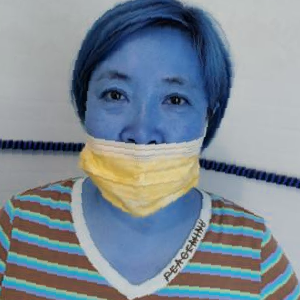

In [128]:
my_data = MyDataset(data_directory, mode='train', transforms=trsfm, resize=None)
transforms.ToPILImage()(next(iter(my_data))[0])

### albumentations
[albumentations](https://github.com/albumentations-team/albumentations)

In [140]:
my_data = MyDataset(data_directory, mode='train', transforms=None, resize=None)
exampe_image = next(iter(my_data))[0]

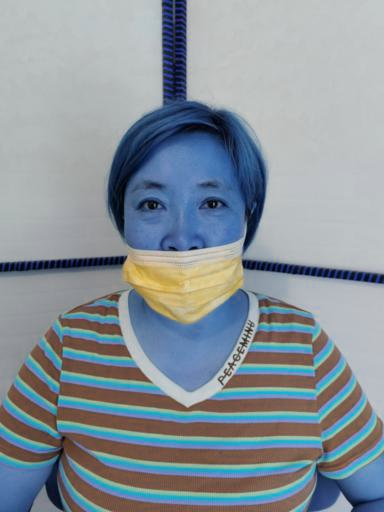

In [142]:
transforms.ToPILImage()(exampe_image)

In [137]:
import albumentations as A

transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

# Read an image with OpenCV and convert it to the RGB colorspace
# image = cv2.imread("image.jpg")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Augment an image
transformed = transform(image=exampe_image)
transformed_image = transformed["image"] # 이 부분이 좀 다르다. data를 dict형태로 뽑아내는 작업이 있다.


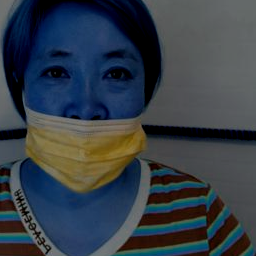

In [139]:
transforms.ToPILImage()(transformed_image)